Starting data loading and preprocessing...
Data and variables prepared successfully.

Loading the trained Keras model...

Starting LIME analysis...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step

Explaining prediction for instance with true class: tvSeries and predicted class: movie
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

LIME Explanation for the top 5 features:
  Feature 'runtimeMinutes > 0.63': Contribution: 0.4107
  Feature '-0.28 < numRegions <= 0.57': Contribution: 0.1400
  Feature 'startYear <= -0.56': Contribution: 0.0845
  Feature 'Asia <= -0.37': Contribution: -0.0830
  Feature 'deltaCredits <= -0.70': Contribution: 0.0642

Starting SHAP analysis...


c:\Users\tanya\anaconda3\Lib\site-packages\shap\explainers\_deep\deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
c:\Users\tanya\anaconda3\Lib\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(100, 20))']
  warnings.warn(msg)
c:\Users\tanya\anaconda3\Lib\site-packages\keras\src\models\functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(200, 20))']
  warnings.warn(msg)


Generating SHAP summary plot...
Summary plot saved as 'shap_summary_plot.png'


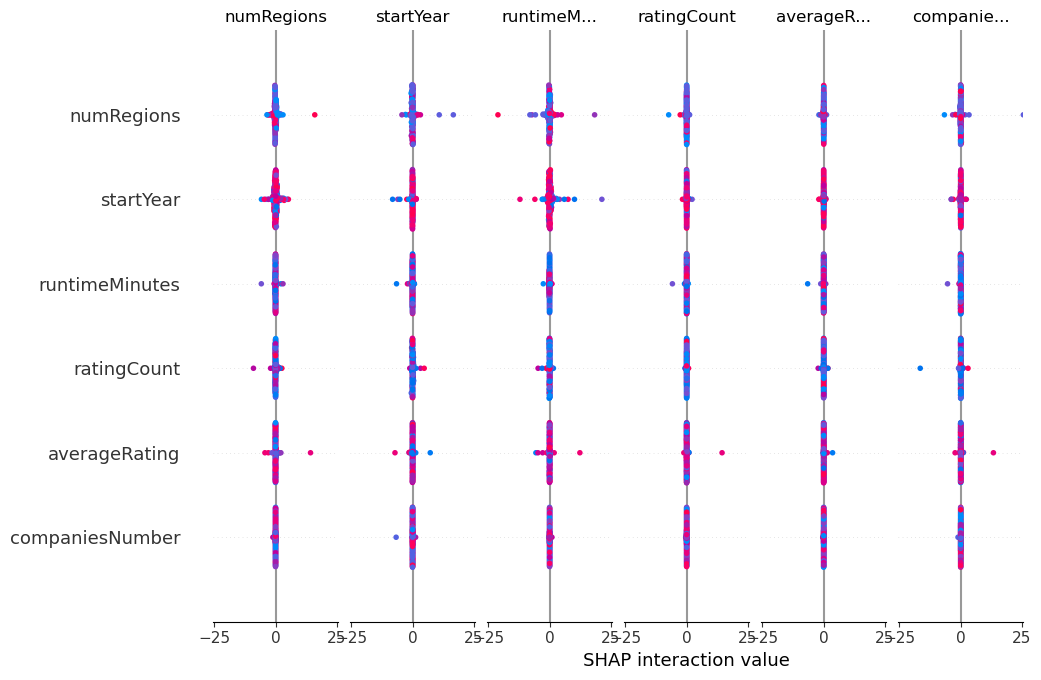


Generating SHAP decision plot for a single prediction...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


ValueError: The feature_names arg must include all features represented in shap_values.

In [1]:
import pandas as pd
import os
import numpy as np
import shap
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow import keras
from lime.lime_tabular import LimeTabularExplainer

# ----------------------------------------------
# 1. Data Loading and Preprocessing
# (Your original code, ensuring consistency)
# ----------------------------------------------
print("Starting data loading and preprocessing...")

parent_dir = os.path.dirname(os.getcwd())
train = pd.read_csv('train70_clf.csv')
test = pd.read_csv('test30_clf.csv')

# Drop observations where titleType is 'videoGame'
train = train[train['titleType'] != 'videoGame']
test = test[test['titleType'] != 'videoGame']

# Define a mapping dictionary for titleType
titletype_mapping = {
    'movie': 'movie',
    'tvMovie': 'movie',
    'short': 'short',
    'tvShort': 'short',
    'tvSeries': 'tvSeries',
    'tvMiniSeries': 'tvSeries',
    'tvEpisode': 'tvEpisode',
    'tvSpecial': 'tvSpecial',
    'video': 'video'
}

# Apply the mapping to the titleType column
train['titleType'] = train['titleType'].map(titletype_mapping)
test['titleType'] = test['titleType'].map(titletype_mapping)

# Define feature names and class names BEFORE scaling
# This is crucial for matching features with SHAP/LIME output
feature_names = train.drop(columns=['titleType', 'canHaveEpisodes']).columns.tolist()
y_train_df = train['titleType']
y_test_df = test['titleType']

# Drop non-feature columns
X_train_df = train.drop(columns=['titleType', 'canHaveEpisodes'])
X_test_df = test.drop(columns=['titleType', 'canHaveEpisodes'])

to_log = [
    'numRegions', 'ratingCount', 'companiesNumber',
    'totalNominations', 'totalMedia', 'totalReviews',
    'deltaCredits'
]

# Apply log transformation safely
for col in to_log:
    X_train_df[col] = np.log1p(X_train_df[col].fillna(0).clip(lower=0))
    X_test_df[col] = np.log1p(X_test_df[col].fillna(0).clip(lower=0))

# Preprocessing: Scale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_df)
X_test = scaler.transform(X_test_df)

# One-hot encode y_train for categorical_crossentropy
le = LabelEncoder()
y_train = le.fit_transform(y_train_df)
y_test = le.transform(y_test_df)
class_names = le.classes_.tolist()
print("Data and variables prepared successfully.")

# ----------------------------------------------
# 2. Model Loading
# ----------------------------------------------
print("\nLoading the trained Keras model...")
# This assumes you have already saved the model with model.save('neural_net_titletype.keras')
model_rating = keras.models.load_model("neural_net_titletype.keras")

# ----------------------------------------------
# 3. LIME Analysis
# ----------------------------------------------
print("\nStarting LIME analysis...")

# Create a LIME explainer
explainer_lime = LimeTabularExplainer(
    training_data=X_train,
    feature_names=feature_names,
    class_names=class_names,
    mode='classification'
)

# Select an instance to explain
single_instance_index = 0
instance_to_explain = X_test[single_instance_index]
true_label = y_test[single_instance_index]
predicted_label = np.argmax(model_rating.predict(instance_to_explain.reshape(1, -1)))

print(f"\nExplaining prediction for instance with true class: {class_names[true_label]} and predicted class: {class_names[predicted_label]}")

# Generate an explanation for the instance
explanation = explainer_lime.explain_instance(
    data_row=instance_to_explain,
    predict_fn=model_rating.predict,
    num_features=5,
    top_labels=len(class_names)
)

print("\nLIME Explanation for the top 5 features:")
for feature_name, contribution in explanation.as_list(label=predicted_label):
    print(f"  Feature '{feature_name}': Contribution: {contribution:.4f}")

# ----------------------------------------------
# 4. SHAP Analysis
# ----------------------------------------------
print("\nStarting SHAP analysis...")

# For DeepExplainer, a background dataset is needed.
background_data = X_train[np.random.choice(X_train.shape[0], 100, replace=False)]

# Create a DeepExplainer for the Keras model
explainer_shap = shap.DeepExplainer(model_rating, background_data)

# Calculate SHAP values for a sample of the test data
test_data_sample_indices = np.random.choice(X_test.shape[0], 200, replace=False)
test_data_sample = X_test[test_data_sample_indices]
shap_values = explainer_shap.shap_values(test_data_sample)

# Generate and save a summary plot for the multi-class model
print("Generating SHAP summary plot...")
shap.summary_plot(shap_values, test_data_sample, feature_names=feature_names, class_names=class_names, show=False)
plt.savefig('shap_summary_plot.png', bbox_inches='tight', dpi=300)
print("Summary plot saved as 'shap_summary_plot.png'")
plt.show()

# Generate and save a decision plot for a single instance
print("\nGenerating SHAP decision plot for a single prediction...")
# Get the expected value for the predicted class of this instance
predicted_class_index = np.argmax(model_rating.predict(test_data_sample[single_instance_index].reshape(1, -1)))
expected_value = explainer_shap.expected_value[predicted_class_index]

# The SHAP values for a single instance for the specific predicted class
single_instance_shap_values = shap_values[predicted_class_index][single_instance_index]

shap.decision_plot(
    expected_value,
    single_instance_shap_values,
    feature_names=feature_names,
    show=False,
    title=f"Decision Plot for Instance Predicting: {class_names[predicted_class_index]}"
)
plt.savefig('shap_decision_plot.png', bbox_inches='tight', dpi=300)
print("Decision plot for a single instance saved as 'shap_decision_plot.png'")
plt.show()

In [10]:
import shap
import matplotlib.pyplot as plt
import numpy as np

# Background dataset for DeepExplainer
background = X_train[np.random.choice(X_train.shape[0], 100, replace=False)]

explainer = shap.DeepExplainer(model_rating, background)

# Sample test data
X_test_sample = X_test[np.random.choice(X_test.shape[0], 200, replace=False)]

# SHAP values for multiclass model
shap_values_list = explainer.shap_values(X_test_sample)

# Loop over each class to generate summary plot
for class_idx, class_name in enumerate(class_names):
    sv = shap_values_list[class_idx]
    
    # Fix possible extra dimension
    if sv.ndim == 3:
        sv = sv.reshape(sv.shape[0], sv.shape[2])  # (n_samples, n_features)
    
    shap.summary_plot(
        sv,
        X_test_sample,
        feature_names=feature_names,
        show=False
    )
    plt.savefig(f'shap_summary_class_{class_name}.png', bbox_inches='tight', dpi=300)
    plt.close()


AssertionError: The shape of the shap_values matrix does not match the shape of the provided data matrix.